In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pickle

In [8]:
full_data = pd.read_csv("kaggle_final.csv")

In [9]:
print(full_data.dtypes)

text                    object
generated                int64
upos_props              object
mean_dep_depth         float64
clause_ratio           float64
voice_ratio            float64
fre                    float64
fog                    float64
chars_per_sent         float64
sents_per_para           int64
nTTR                   float64
word_density           float64
perplexity             float64
burstiness             float64
p_t                    float64
lexical_spike_delta    float64
avg_line_len           float64
dtype: object


In [66]:
import pandas as pd
import numpy as np

def normalize_features_from_labels(
    df: pd.DataFrame,
    raw_feature_cols: list[str],
    label_col: str = 'generated',
    human_label_value: int = 0
) -> pd.DataFrame:
    """
    Computes baseline statistics from human-labeled data and uses them to
    generate z-score normalized columns for the entire DataFrame.

    This is a simplified, purpose-built function for labeled datasets that
    uses a robust method for calculation to avoid ufunc errors.

    Args:
        df (pd.DataFrame): The input DataFrame containing raw features and a ground truth label.
        raw_feature_cols (list[str]): A list of the raw feature columns to normalize.
        label_col (str): The name of the column containing the ground truth labels.
        human_label_value (int): The value in the label column that represents human text.

    Returns:
        pd.DataFrame: A new DataFrame with the original data plus the new z-score columns.
    """
    print(f"Normalizing {len(raw_feature_cols)} features...")
    print(f"Using rows where '{label_col} == {human_label_value}' as the human baseline.")

    out_df = df.copy()
    human_df = out_df[out_df[label_col] == human_label_value]

    if len(human_df) == 0:
        raise ValueError(f"No baseline data found. No rows have '{label_col} == {human_label_value}'.")

    baseline_stats = human_df[raw_feature_cols].agg(['mean', 'std'])
    print("Computed baseline statistics (mean and std) from human-written text.")

    # --- CORRECTED Z-SCORE CALCULATION LOOP ---
    for col in raw_feature_cols:
        z_score_col = f"{col}_zscore"

        mean_val = baseline_stats.loc['mean', col]
        std_val = baseline_stats.loc['std', col]

        # Explicitly check if the standard deviation is valid before dividing.
        # This is a more robust approach than using np.divide with 'where'.
        if pd.notna(std_val) and std_val != 0:
            # If std is a valid, non-zero number, perform the standard calculation.
            out_df[z_score_col] = (out_df[col] - mean_val) / std_val
        else:
            # If std is zero or NaN, the z-score is undefined. We assign 0.0.
            out_df[z_score_col] = 0.0

    print("Z-score normalization complete.")
    return out_df

In [67]:
# === Cell: Normalize current feature set ===
# initialize new_df as a copy of full_data
new_df = full_data.copy()
# Define the raw feature columns you want to normalize
raw_features = [
    'p_t', 'lexical_spike_delta', 'perplexity', 'burstiness',
    'mean_dep_depth', 'clause_ratio', 'voice_ratio', 'fre', 'fog',
    'chars_per_sent', 'sents_per_para', 'avg_line_len', 'nTTR',
    'word_density'
]
# Filter for only those that exist in the dataframe
raw_features = [f for f in raw_features if f in new_df.columns]

# Run the entire normalization process with one simple function call
normalized_df = normalize_features_from_labels(
    df=new_df,
    raw_feature_cols=raw_features
)

# Display the first few rows with the new z-score columns
print("\n--- Resulting DataFrame ---")
display(normalized_df.head())
# Optional: save
normalized_df.to_csv("new_dataset_normalized_global.csv", index=False)



Normalizing 14 features...
Using rows where 'generated == 0' as the human baseline.
Computed baseline statistics (mean and std) from human-written text.
Z-score normalization complete.

--- Resulting DataFrame ---


,text,generated,upos_props,mean_dep_depth,clause_ratio,voice_ratio,fre,fog,chars_per_sent,sents_per_para,...,mean_dep_depth_zscore,clause_ratio_zscore,voice_ratio_zscore,fre_zscore,fog_zscore,chars_per_sent_zscore,sents_per_para_zscore,avg_line_len_zscore,nTTR_zscore,word_density_zscore
0,Car-free cities have become a subject of incre...,1,"{'NOUN': 0.28328611898017, 'PUNCT': 0.12606232...",3.021246,0.470588,0.995751,18.115424,19.136025,119.794118,34,...,0.311733,-0.834925,0.467998,-2.533865,1.068072,0.004293,1.235579,13.061287,1.165183,-1.000129
1,"Car Free Cities Car-free cities, a concept ga...",1,"{'NOUN': 0.29439252336448596, 'PROPN': 0.02803...",3.127726,0.481481,0.996885,16.453883,19.276323,138.592593,27,...,0.518658,-0.826622,0.665305,-2.631467,1.090716,0.319519,0.534122,11.900679,1.610224,-0.845060
2,A Sustainable Urban Future Car-free cities ...,1,"{'SPACE': 0.025039123630672927, 'DET': 0.05164...",3.164319,0.482759,0.995305,11.943452,19.694560,131.448276,29,...,0.589772,-0.825649,0.390479,-2.896418,1.158219,0.199718,0.734539,12.147396,-0.763330,-1.129861
3,Pioneering Sustainable Urban Living In an e...,1,"{'SPACE': 0.02358490566037736, 'VERB': 0.08805...",3.256289,0.400000,0.993711,13.916275,20.201424,149.040000,25,...,0.768501,-0.888727,0.113060,-2.780531,1.240027,0.494709,0.333706,11.838132,1.610224,-0.838606
4,The Path to Sustainable Urban Living In an ...,1,"{'SPACE': 0.023734177215189875, 'DET': 0.06803...",3.245253,0.521739,0.996835,11.410395,21.032592,160.304348,23,...,0.747054,-0.795938,0.656729,-2.927730,1.374177,0.683597,0.133290,11.695662,1.016836,-0.890936


In [75]:
import pandas as pd
import numpy as np

def verify_zscore_calculation(
    df: pd.DataFrame,
    raw_feature: str,
    label_col: str = 'generated',
    human_label_value: int = 0
):
    """
    Verifies the z-score calculation for a single feature by manually
    re-computing it and comparing it against the existing z-score column.

    Args:
        df (pd.DataFrame): The DataFrame containing raw and z-score columns.
        raw_feature (str): The name of the raw feature to check (e.g., 'p_t').
        label_col (str): The column with the ground truth label.
        human_label_value (int): The value representing human text.
    """
    zscore_feature = f"{raw_feature}_zscore"

    print(f"--- Verifying Z-Score for feature: '{raw_feature}' ---")

    # Check if required columns exist
    if raw_feature not in df.columns or zscore_feature not in df.columns:
        print(f"Error: Missing required columns. Ensure '{raw_feature}' and '{zscore_feature}' are in the DataFrame.")
        return

    # 1. Isolate the human-only data to compute our own baseline stats
    human_df = df[df[label_col] == human_label_value]

    if len(human_df) == 0:
        print(f"Error: No baseline data found for verification.")
        return

    # 2. Calculate the mean and standard deviation from the baseline
    human_mean = human_df[raw_feature].mean()
    human_std = human_df[raw_feature].std()

    print(f"Manual Baseline Calculation for '{raw_feature}':")
    print(f"  - Mean: {human_mean:.6f}")
    print(f"  - Std Dev: {human_std:.6f}\n")

    # 3. Manual Spot-Check: Pick one AI-generated row and one human-written row
    ai_sample = df[df[label_col] == 1].iloc[0]
    human_sample = df[df[label_col] == 0].iloc[0]

    manual_z_ai = (ai_sample[raw_feature] - human_mean) / human_std
    manual_z_human = (human_sample[raw_feature] - human_mean) / human_std

    print("Manual Spot-Check:")
    print(f"  - AI Sample (Index {ai_sample.name}):")
    print(f"    - Raw Value: {ai_sample[raw_feature]:.4f}")
    print(f"    - Manually Computed Z-Score: {manual_z_ai:.4f}")
    print(f"    - Function's Z-Score:        {ai_sample[zscore_feature]:.4f}")

    print(f"  - Human Sample (Index {human_sample.name}):")
    print(f"    - Raw Value: {human_sample[raw_feature]:.4f}")
    print(f"    - Manually Computed Z-Score: {manual_z_human:.4f}")
    print(f"    - Function's Z-Score:        {human_sample[zscore_feature]:.4f}\n")


    # 4. Full Column Verification
    print("Full Column Verification:")

    # Manually compute the entire z-score column
    manually_computed_zscores = (df[raw_feature] - human_mean) / human_std

    # Fill any potential NaNs (from std=0 cases) with 0, to match function's behavior
    function_zscores = df[zscore_feature].fillna(0)
    manually_computed_zscores = manually_computed_zscores.fillna(0)

    # Use np.allclose to compare the two columns, which is robust to tiny floating point differences
    are_they_equal = np.allclose(function_zscores, manually_computed_zscores)

    if are_they_equal:
        print("✅ SUCCESS: The function's z-score column matches the manually computed column.")
    else:
        # If they don't match, show the difference for the first few rows
        print("❌ FAILURE: The columns do not match.")
        diff_df = pd.DataFrame({
            'function_z': function_zscores,
            'manual_z': manually_computed_zscores,
            'difference': function_zscores - manually_computed_zscores
        })
        print("Showing first 5 rows with differences:")
        display(diff_df[diff_df['difference'].abs() > 1e-9].head())

    print("-" * 50)


# --- EXAMPLE USAGE ---
# Assumes you have your 'normalized_df' DataFrame ready from the previous step.

# Verify one of the most important features
verify_zscore_calculation(normalized_df, 'p_t')

# Verify another important feature
verify_zscore_calculation(normalized_df, 'fre')

--- Verifying Z-Score for feature: 'p_t' ---
Manual Baseline Calculation for 'p_t':
  - Mean: 0.016594
  - Std Dev: 0.011160

Manual Spot-Check:
  - AI Sample (Index 0):
    - Raw Value: 0.0769
    - Manually Computed Z-Score: 5.4058
    - Function's Z-Score:        5.4058
  - Human Sample (Index 749):
    - Raw Value: 0.0085
    - Manually Computed Z-Score: -0.7249
    - Function's Z-Score:        -0.7249

Full Column Verification:
✅ SUCCESS: The function's z-score column matches the manually computed column.
--------------------------------------------------
--- Verifying Z-Score for feature: 'fre' ---
Manual Baseline Calculation for 'fre':
  - Mean: 61.251146
  - Std Dev: 17.023683

Manual Spot-Check:
  - AI Sample (Index 0):
    - Raw Value: 18.1154
    - Manually Computed Z-Score: -2.5339
    - Function's Z-Score:        -2.5339
  - Human Sample (Index 749):
    - Raw Value: 58.9433
    - Manually Computed Z-Score: -0.1356
    - Function's Z-Score:        -0.1356

Full Column Veri

In [76]:
# ... existing code ...
import pandas as pd
import numpy as np

# or fall back to features_df_z if you are still using the per‑category path.
df_for_voting = normalized_df if 'new_df_z' in globals() else full_data.copy()

# --- 1. Define the z-score columns to be used in the voting system ---
# Prefer the explicit list created during normalization; otherwise auto-detect.
if 'zscore_cols' not in globals():
    zscore_cols = [col for col in df_for_voting.columns if col.endswith('_zscore')]

# Guard: ensure we have at least one z-score column
if not zscore_cols:
    raise ValueError("No z-score columns found for voting.")

# --- 2. Voting function (unchanged logic, robust to any df shape) ---
def apply_voting_system_zscore(df, z_score_cutoff=2.5, min_votes=3):
    """
    Applies a voting system to flag rows based on a z-score cutoff.
    Adds 'ai_vote_count' and 'ai_flag' columns.
    """
    print(f"Applying voting system with Z-Score cutoff: {z_score_cutoff} and minimum votes: {min_votes}")
    df = df.copy()
    df['ai_vote_count'] = df[zscore_cols].abs().gt(z_score_cutoff).sum(axis=1)
    df['ai_flag'] = df['ai_vote_count'] >= min_votes
    print("Voting system application complete.")
    return df

# --- 3. Apply the voting system ---
Z_SCORE_THRESHOLD = 2
MINIMUM_VOTES = 2

final_df = apply_voting_system_zscore(
    df_for_voting,
    z_score_cutoff=Z_SCORE_THRESHOLD,
    min_votes=MINIMUM_VOTES
)

# --- 4. Display results robustly (only show columns that actually exist) ---
display_cols =  ['ai_vote_count', 'ai_flag']

print("\n--- Voting System Results (sample) ---")
print(final_df[display_cols].head())

print("\n--- Distribution of Votes ---")
print(final_df['ai_vote_count'].value_counts().sort_index())

flagged_count = int(final_df['ai_flag'].sum())
total_count = int(len(final_df))
pct = (flagged_count / total_count) * 100 if total_count else 0.0
print(f"\nTotal rows flagged: {flagged_count} of {total_count} ({pct:.2f}%)")

# Optional: save with a name appropriate for the new dataset
final_df.to_csv("new_dataset_normalized_with_ai_votes.csv", index=False)
# ... existing code ...

Applying voting system with Z-Score cutoff: 2 and minimum votes: 2
Voting system application complete.

--- Voting System Results (sample) ---
   ai_vote_count  ai_flag
0              4     True
1              4     True
2              4     True
3              4     True
4              5     True

--- Distribution of Votes ---
ai_vote_count
0     14068
1      4679
2      5171
3      2461
4      1062
5       874
6       613
7       159
8        55
9         2
10        1
Name: count, dtype: int64

Total rows flagged: 10398 of 29145 (35.68%)


In [77]:
final_df

,text,generated,upos_props,mean_dep_depth,clause_ratio,voice_ratio,fre,fog,chars_per_sent,sents_per_para,...,voice_ratio_zscore,fre_zscore,fog_zscore,chars_per_sent_zscore,sents_per_para_zscore,avg_line_len_zscore,nTTR_zscore,word_density_zscore,ai_vote_count,ai_flag
0,Car-free cities have become a subject of incre...,1,"{'NOUN': 0.28328611898017, 'PUNCT': 0.12606232...",3.021246,0.470588,0.995751,18.115424,19.136025,119.794118,34,...,0.467998,-2.533865,1.068072,0.004293,1.235579,13.061287,1.165183,-1.000129,4,True
1,"Car Free Cities Car-free cities, a concept ga...",1,"{'NOUN': 0.29439252336448596, 'PROPN': 0.02803...",3.127726,0.481481,0.996885,16.453883,19.276323,138.592593,27,...,0.665305,-2.631467,1.090716,0.319519,0.534122,11.900679,1.610224,-0.845060,4,True
2,A Sustainable Urban Future Car-free cities ...,1,"{'SPACE': 0.025039123630672927, 'DET': 0.05164...",3.164319,0.482759,0.995305,11.943452,19.694560,131.448276,29,...,0.390479,-2.896418,1.158219,0.199718,0.734539,12.147396,-0.763330,-1.129861,4,True
3,Pioneering Sustainable Urban Living In an e...,1,"{'SPACE': 0.02358490566037736, 'VERB': 0.08805...",3.256289,0.400000,0.993711,13.916275,20.201424,149.040000,25,...,0.113060,-2.780531,1.240027,0.494709,0.333706,11.838132,1.610224,-0.838606,4,True
4,The Path to Sustainable Urban Living In an ...,1,"{'SPACE': 0.023734177215189875, 'DET': 0.06803...",3.245253,0.521739,0.996835,11.410395,21.032592,160.304348,23,...,0.656729,-2.927730,1.374177,0.683597,0.133290,11.695662,1.016836,-0.890936,5,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29140,There has been a fuss about the Elector Colleg...,0,"{'PRON': 0.09406952965235174, 'AUX': 0.0695296...",2.451943,0.612903,0.989775,67.575668,10.754990,76.774194,31,...,-0.571695,0.371513,-0.284620,-0.717095,0.934955,-0.228560,0.423447,-0.292681,0,False
29141,Limiting car usage has many advantages. Such a...,0,"{'VERB': 0.1773049645390071, 'NOUN': 0.2033096...",3.375887,1.647059,1.000000,70.402797,11.658557,121.176471,17,...,1.207324,0.537584,-0.138785,0.027473,-0.467958,-0.128340,-0.021594,-0.079779,0,False
29142,There's a new trend that has been developing f...,0,"{'PRON': 0.03747072599531616, 'VERB': 0.120608...",2.738876,0.833333,0.990632,55.824170,13.342249,119.638889,36,...,-0.422541,-0.318790,0.132962,0.001690,1.435995,0.996526,1.313530,-1.051999,0,False
29143,As we all know cars are a big part of our soci...,0,"{'SCONJ': 0.02702702702702703, 'PRON': 0.09797...",2.570946,0.818182,0.998311,73.354085,9.381548,84.333333,33,...,0.913426,0.710947,-0.506292,-0.590338,1.135371,-0.072576,-0.318289,-0.676614,0,False


In [73]:
# how many rows were flagged as ai_flag out of the ones with the flag generated
generated = final_df['generated'].sum()

flagged = final_df['ai_flag'].sum()

print(f"Generated: {generated}, Flagged: {flagged}, Percentage: {flagged/generated*100:.2f}%")
print(f"parameters: z_score_cutoff =,{Z_SCORE_THRESHOLD}, min_votes = {MINIMUM_VOTES}")

# compute confusion matrix, where generated = 1 is positive class, and ai_flag = 1 is positive prediction
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(final_df['generated'], final_df['ai_flag'])
print("Confusion Matrix:")
print(cm)

#also cm in percentage
cm_percentage = cm / cm.sum(axis=1, keepdims=True) * 100
print("Confusion Matrix in Percentage:")

print(cm_percentage)



Generated: 11637, Flagged: 10398, Percentage: 89.35%
parameters: z_score_cutoff =,2, min_votes = 2
Confusion Matrix:
[[15733  1775]
 [ 3014  8623]]
Confusion Matrix in Percentage:
[[89.86177747 10.13822253]
 [25.90014609 74.09985391]]


In [74]:
# save to a file called normalized_everything100percat_with_ai_votes.csv
final_df.to_csv("KAGGLE_normalized_everything100percat_with_ai_votes.csv", index=False)

In [78]:
import pandas as pd
import numpy as np

# Assume 'features_df_z' is the DataFrame that has been processed by your
# normalize_features_by_baseline() function and contains all z-score columns.

# --- 1. Isolate the Baseline Data for Calibration ---
# We only want to test our parameters on the data we know should be "human".

# Ensure timestamp column is in datetime format for comparison
# features_df_z['timestamp'] = pd.to_datetime(features_df_z['timestamp'])
# baseline_df = features_df_z[features_df_z['timestamp'] < baseline_end_date].copy()
# baseline_df, rows from final_df where generated = 0
baseline_df = final_df[final_df['generated'] == 0].copy()


# --- 2. Define the Grid of Parameters to Test ---
z_score_cutoffs = [2.0, 2.5, 3.0, 3.5]
min_votes_options = [2, 3, 4, 5, 6]

# The list of z-score columns to use for voting
zscore_cols = [col for col in final_df.columns if col.endswith('_zscore')]

# --- 3. Perform the Grid Search ---
results = []

for z_cutoff in z_score_cutoffs:
    row = {'z_score_cutoff': z_cutoff}
    for min_v in min_votes_options:
        # Calculate votes for the current parameter combination
        vote_count = baseline_df[zscore_cols].abs().gt(z_cutoff).sum(axis=1)

        # Determine the number of revisions flagged
        flagged_count = (vote_count >= min_v).sum()

        # Calculate the percentage of the baseline that was flagged (Baseline Flag Rate)
        baseline_flag_rate = (flagged_count / len(baseline_df)) * 100

        # Store the result, formatted as a percentage string
        row[f'min_votes_{min_v}'] = f"{baseline_flag_rate:.2f}%"

    results.append(row)

# --- 4. Display the Results in a Clear Table ---
calibration_results_df = pd.DataFrame(results).set_index('z_score_cutoff')

print("\n--- Calibration Results (Baseline Flag Rate %) ---")
print("This table shows the percentage of the baseline data that was flagged for each combination of parameters tested.")
print(calibration_results_df)




--- Calibration Results (Baseline Flag Rate %) ---
This table shows the percentage of the baseline data that was flagged for each combination of parameters tested.
               min_votes_2 min_votes_3 min_votes_4 min_votes_5 min_votes_6
z_score_cutoff                                                            
2.0                 10.14%       3.68%       1.70%       1.07%       0.53%
2.5                  5.44%       1.83%       1.01%       0.69%       0.22%
3.0                  3.00%       1.05%       0.62%       0.42%       0.10%
3.5                  1.91%       0.74%       0.42%       0.27%       0.05%


I have created a Python script that does exactly what you've asked for. It systematically tests a grid of z_score_cutoff and min_votes parameters against your ground truth data (generated column) and then produces two essential visualizations to help you interpret the results:

A Recall vs. False Positive Rate Plot (ROC-like Curve): This is the most important visual. It helps you see which parameter settings give you the highest AI detection rate (Recall) for the lowest cost of flagging human text (False Positive Rate). The best parameters will be in the top-left corner.

A Precision-Recall Curve: This plot shows a different, but equally important, trade-off. It helps you see which settings give you the highest confidence that a flag is correct (Precision) while still catching a good number of AI texts (Recall). The best parameters here will be in the top-r

In [79]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_detector_performance(df, z_score_cutoffs, min_votes_options):
    """
    Performs a grid search over z-score and min_votes parameters,
    calculates confusion matrix metrics against a ground truth 'generated' column,
    and returns the results in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing z-score columns and a 'generated' column.
        z_score_cutoffs (list): A list of z-score thresholds to test.
        min_votes_options (list): A list of minimum vote thresholds to test.

    Returns:
        pd.DataFrame: A DataFrame with performance metrics for each parameter combination.
    """
    # Find all z-score columns to use for voting
    zscore_cols = [col for col in df.columns if col.endswith('_zscore')]
    if not zscore_cols:
        raise ValueError("No z-score columns found in the DataFrame.")

    # Get the ground truth labels
    y_true = df['generated']

    results = []

    print("Running Grid Search for Detector Parameters...")
    for z_cutoff in z_score_cutoffs:
        # Pre-calculate the vote count for the current z-score cutoff to save time
        vote_counts = df[zscore_cols].abs().gt(z_cutoff).sum(axis=1)

        for min_v in min_votes_options:
            # Get the model's predictions for this parameter combination
            y_pred = (vote_counts >= min_v).astype(int)

            # Calculate the confusion matrix
            tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

            # Calculate performance metrics, handling division by zero
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            results.append({
                'z_score_cutoff': z_cutoff,
                'min_votes': min_v,
                'Recall (TPR)': recall,
                'Precision': precision,
                'False Positive Rate (FPR)': fpr,
                'F1-Score': f1_score,
                'True Positives': tp,
                'False Positives': fp,
                'True Negatives': tn,
                'False Negatives': fn
            })

    print("Grid Search Complete.")
    return pd.DataFrame(results)

def plot_performance_curves(results_df):
    """
    Generates and displays Recall vs. FPR and Precision vs. Recall curves.
    """
    sns.set_theme(style="whitegrid")

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # --- Plot 1: Recall vs. False Positive Rate (ROC-like curve) ---
    ax1.set_title('Detector Performance: Recall vs. False Positive Rate', fontsize=16, weight='bold')
    sns.lineplot(
        data=results_df,
        x='False Positive Rate (FPR)',
        y='Recall (TPR)',
        hue='z_score_cutoff',
        palette='viridis',
        marker='o',
        ax=ax1,
        legend='full'
    )
    ax1.set_xlabel('False Positive Rate (Cost)', fontsize=12)
    ax1.set_ylabel('Recall / True Positive Rate (Benefit)', fontsize=12)
    ax1.legend(title='Z-Score Cutoff')
    ax1.text(0.95, 0.05, 'Goal: Top-Left', transform=ax1.transAxes, fontsize=12,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    # --- Plot 2: Precision vs. Recall Curve ---
    ax2.set_title('Detector Performance: Precision vs. Recall', fontsize=16, weight='bold')
    sns.lineplot(
        data=results_df,
        x='Recall (TPR)',
        y='Precision',
        hue='z_score_cutoff',
        palette='viridis',
        marker='o',
        ax=ax2,
        legend='full'
    )
    ax2.set_xlabel('Recall / True Positive Rate', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.legend(title='Z-Score Cutoff')
    ax2.text(0.05, 0.05, 'Goal: Top-Right', transform=ax2.transAxes, fontsize=12,
             verticalalignment='bottom', horizontalalignment='left',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


Running Grid Search for Detector Parameters...
Grid Search Complete.

--- Full Performance Metrics ---
    z_score_cutoff  min_votes  Recall (TPR)  Precision  False Positive Rate (FPR)  F1-Score  True Positives  False Positives  True Negatives  False Negatives
0              2.0          2      0.740999   0.829294                   0.101382  0.782664            8623             1775           15733             3014
1              2.0          3      0.393830   0.876794                   0.036783  0.543525            4583              644           16864             7054
2              2.0          4      0.212082   0.892263                   0.017021  0.342706            2468              298           17210             9169
3              2.0          5      0.130274   0.889671                   0.010738  0.227269            1516              188           17320            10121
4              2.0          6      0.063332   0.887952                   0.005312  0.118232             737

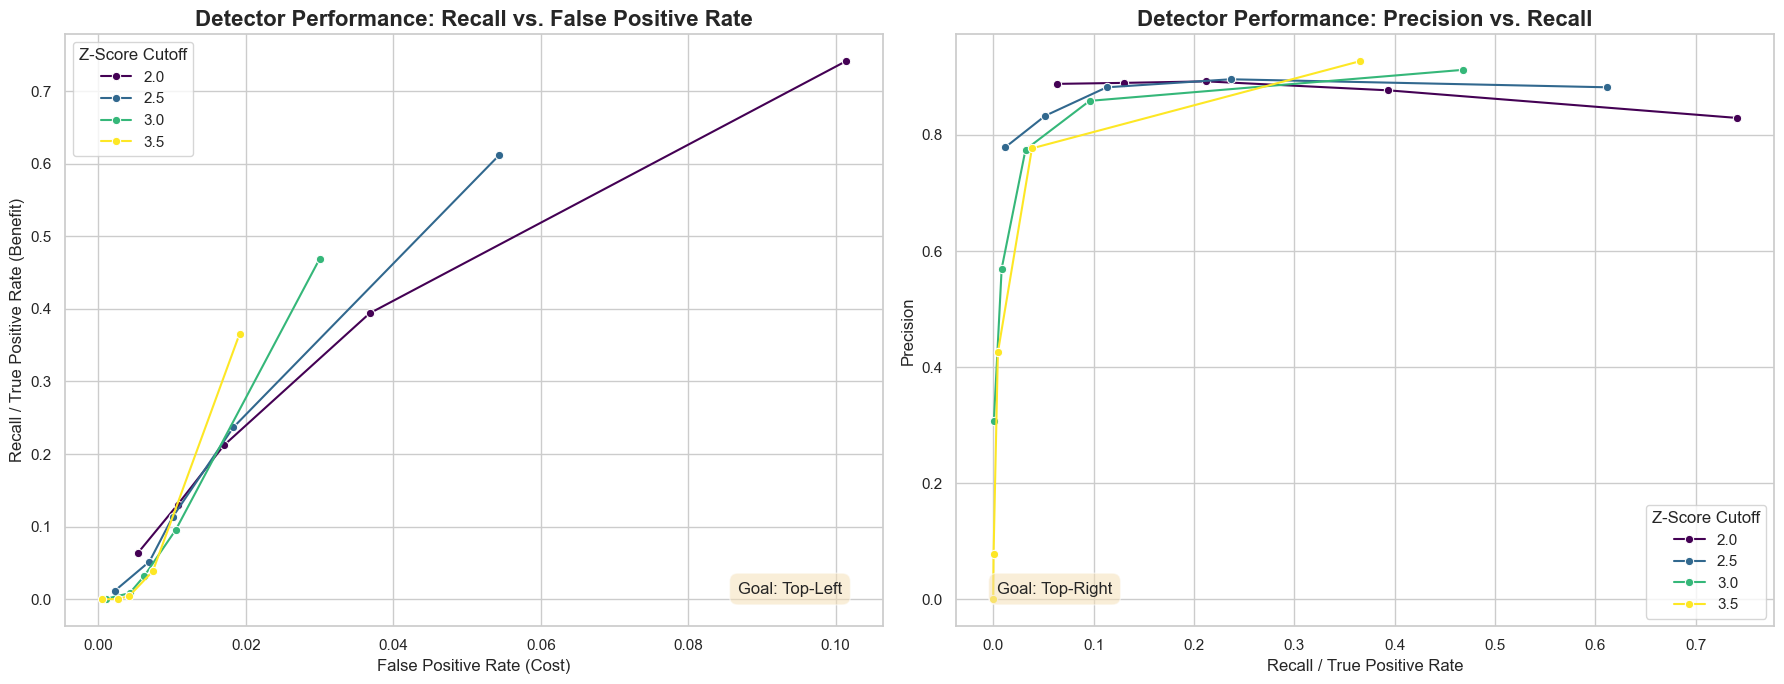

In [80]:
features_df_z = final_df.copy()  # Replace with your actual DataFrame variable
# END DUMMY DATA

# Define the grid of parameters to test
z_score_cutoffs_to_test = [2.0, 2.5, 3.0, 3.5]
min_votes_to_test = [2, 3, 4, 5, 6]

# Run the analysis
performance_results = analyze_detector_performance(
    df=features_df_z,
    z_score_cutoffs=z_score_cutoffs_to_test,
    min_votes_options=min_votes_to_test
)

# Display the full results table
print("\n--- Full Performance Metrics ---")
print(performance_results.to_string())

# Plot the performance curves
plot_performance_curves(performance_results)


In [81]:
final_df.columns

Index(['text', 'generated', 'upos_props', 'mean_dep_depth', 'clause_ratio',
       'voice_ratio', 'fre', 'fog', 'chars_per_sent', 'sents_per_para', 'nTTR',
       'word_density', 'perplexity', 'burstiness', 'p_t',
       'lexical_spike_delta', 'avg_line_len', 'p_t_zscore',
       'lexical_spike_delta_zscore', 'perplexity_zscore', 'burstiness_zscore',
       'mean_dep_depth_zscore', 'clause_ratio_zscore', 'voice_ratio_zscore',
       'fre_zscore', 'fog_zscore', 'chars_per_sent_zscore',
       'sents_per_para_zscore', 'avg_line_len_zscore', 'nTTR_zscore',
       'word_density_zscore', 'ai_vote_count', 'ai_flag'],
      dtype='object')

# from data_analysis python file


Analyzing 14 z-score features against the 'generated' target.

Calculating Pearson Correlation...
Top 10 features by |Correlation|:
lexical_spike_delta_zscore    0.677770
p_t_zscore                    0.677770
fre_zscore                    0.537387
sents_per_para_zscore         0.363320
fog_zscore                    0.305267
mean_dep_depth_zscore         0.245536
word_density_zscore           0.244721
perplexity_zscore             0.238276
nTTR_zscore                   0.222411
chars_per_sent_zscore         0.196401
Name: generated, dtype: float64

Training Logistic Regression model...
Top 10 features by |Logistic Regression Coefficient|:
fre_zscore                    5.436310
perplexity_zscore             4.287935
fog_zscore                    3.391632
sents_per_para_zscore         1.120778
lexical_spike_delta_zscore    0.809532
p_t_zscore                    0.809532
word_density_zscore           0.758440
chars_per_sent_zscore         0.674339
clause_ratio_zscore           0.640950
me

C:\Users\david\AppData\Local\Temp\ipykernel_35820\1341579514.py:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features['Correlation'], y=top_10_features.index, ax=axes[0], palette='viridis')
C:\Users\david\AppData\Local\Temp\ipykernel_35820\1341579514.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features['LogReg_Coefficient'], y=top_10_features.index, ax=axes[1], palette='plasma')
C:\Users\david\AppData\Local\Temp\ipykernel_35820\1341579514.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features[

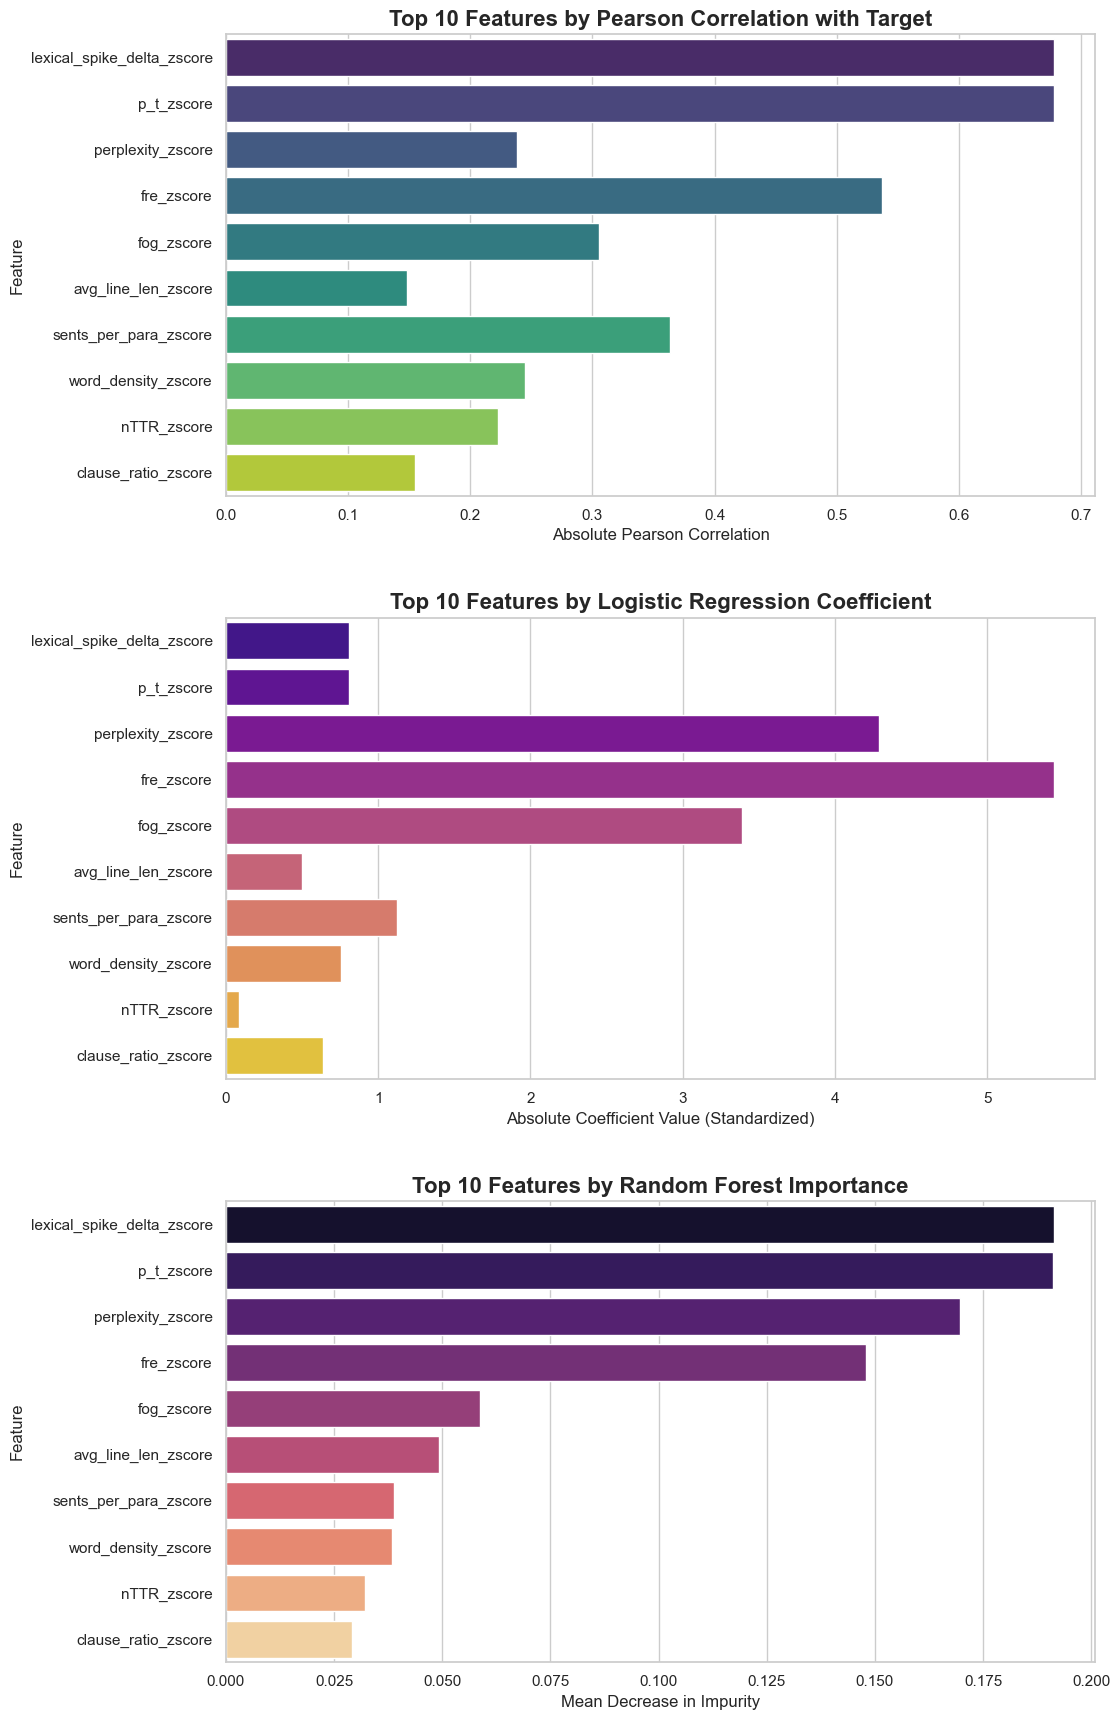

In [84]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Setup: Load data and identify feature/target columns ---

# Use the final_df which contains the ground truth and z-score features
# Create a copy to ensure the original DataFrame is not modified
df = final_df.copy()

# Identify the z-score feature columns for analysis. This is the set of
# features your actual detector uses.
feature_cols = [c for c in df.columns if c.endswith('_zscore')]

# Define the target variable from the ground truth
target_col = 'generated'

print(f"Analyzing {len(feature_cols)} z-score features against the '{target_col}' target.")

# --- 2. Prepare X (features) and y (target) for modeling ---
X = df[feature_cols]
y = df[target_col].astype(int)

# --- 3. Preprocessing: Impute and Scale ---
# Impute missing values (e.g., if a category had no baseline, z-scores might be NaN)
imputer = SimpleImputer(strategy='median')
X_imp = imputer.fit_transform(X)

# Scale data for Logistic Regression. It's essential for comparing coefficient magnitudes.
scaler = StandardScaler()
X_std = scaler.fit_transform(X_imp)

# --- 4. Run Analyses ---

# === METHOD 1: Pearson Correlation ===
print("\nCalculating Pearson Correlation...")
# A clean way to calculate correlation with the target column
corr_with_target = df[feature_cols + [target_col]].corr(numeric_only=True)[target_col]
corr_series = corr_with_target.drop(target_col).abs().sort_values(ascending=False)
print("Top 10 features by |Correlation|:")
print(corr_series.head(10))


# === METHOD 2: Logistic Regression Coefficients ===
print("\nTraining Logistic Regression model...")
lr = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000)
lr.fit(X_std, y)
lr_coef = pd.Series(np.abs(lr.coef_[0]), index=feature_cols).sort_values(ascending=False)
print("Top 10 features by |Logistic Regression Coefficient|:")
print(lr_coef.head(10))


# === METHOD 3: Random Forest Feature Importances ===
print("\nTraining Random Forest model...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# Random Forest does not require scaled data
rf.fit(X_imp, y)
rf_imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("Top 10 features by Random Forest Importance:")
print(rf_imp.head(10))


# --- 5. Combine and Display Summary Table ---
summary_df = pd.concat({
    'Correlation': corr_series,
    'LogReg_Coefficient': lr_coef,
    'RF_Importance': rf_imp
}, axis=1).sort_values(by='RF_Importance', ascending=False)

print("\n--- Combined Feature Importance Summary ---")
# Displaying all features for a complete view
print(summary_df.to_string())


# --- 6. Visualization ---
print("\nGenerating feature importance plots...")

# Get the top 10 features based on Random Forest importance for plotting
top_10_features = summary_df.head(10)

fig, axes = plt.subplots(3, 1, figsize=(12, 18))
sns.set_theme(style="whitegrid")

# Plot 1: Correlation
sns.barplot(x=top_10_features['Correlation'], y=top_10_features.index, ax=axes[0], palette='viridis')
axes[0].set_title('Top 10 Features by Pearson Correlation with Target', fontsize=16, weight='bold')
axes[0].set_xlabel('Absolute Pearson Correlation', fontsize=12)
axes[0].set_ylabel('Feature', fontsize=12)

# Plot 2: Logistic Regression Coefficients
sns.barplot(x=top_10_features['LogReg_Coefficient'], y=top_10_features.index, ax=axes[1], palette='plasma')
axes[1].set_title('Top 10 Features by Logistic Regression Coefficient', fontsize=16, weight='bold')
axes[1].set_xlabel('Absolute Coefficient Value (Standardized)', fontsize=12)
axes[1].set_ylabel('Feature', fontsize=12)

# Plot 3: Random Forest Importance
sns.barplot(x=top_10_features['RF_Importance'], y=top_10_features.index, ax=axes[2], palette='magma')
axes[2].set_title('Top 10 Features by Random Forest Importance', fontsize=16, weight='bold')
axes[2].set_xlabel('Mean Decrease in Impurity', fontsize=12)
axes[2].set_ylabel('Feature', fontsize=12)

plt.tight_layout(pad=3.0)
plt.show()


In [54]:
feature_cols

['p_t_zscore',
 'lexical_spike_delta_zscore',
 'perplexity_zscore',
 'burstiness_zscore',
 'mean_dep_depth_zscore',
 'clause_ratio_zscore',
 'voice_ratio_zscore',
 'fre_zscore',
 'fog_zscore',
 'chars_per_sent_zscore',
 'sents_per_para_zscore',
 'avg_line_len_zscore',
 'nTTR_zscore',
 'word_density_zscore']

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

def run_descriptive_analysis(df, feature_cols, target_col='generated', analysis_type='Z-Score'):
    """
    Computes and displays descriptive statistics for a list of feature columns,
    grouped by a binary target column. This version uses a robust styling
    function to prevent KeyErrors.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        feature_cols (list): A list of the feature columns to analyze.
        target_col (str): The name of the ground truth column.
        analysis_type (str): A label for the output title (e.g., 'Z-Score' or 'Raw').

    Returns:
        pd.io.formats.style.Styler: A styled DataFrame with the comparative statistics.
    """
    if target_col not in df.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    print(f"--- Comparative Descriptive Statistics for {len(feature_cols)} {analysis_type} Features ---")
    print(f"Comparing Human-Written (generated=0) vs. AI-Generated (generated=1) text.\n")

    # Group by the target, get stats, and transpose
    stats = df.groupby(target_col)[feature_cols].describe().T

    # --- ROBUST STYLING FUNCTION ---
    def highlight_mean_row(row):
        """
        Applies a background gradient ONLY to rows that are 'mean' statistics.
        Returns default style for all other rows.
        """
        styles = [''] * len(row)  # Default: no style
        if row.name[1] == 'mean':
            # Create a color map and normalize the data for the current row
            cmap = sns.color_palette("RdYlGn", as_cmap=True)
            norm = mcolors.Normalize(vmin=row.min(), vmax=row.max())

            # Generate CSS style strings for each cell in the row
            styles = [f'background-color: {mcolors.to_hex(cmap(norm(val)))}' for val in row]
        return styles

    # Apply the styling function row-wise (axis=1) and format the numbers
    styled_stats = stats.style.apply(highlight_mean_row, axis=1).format("{:.3f}")

    return styled_stats

# --- Main execution block ---
# NOTE: Ensure your final DataFrame is named 'final_df'.

# --- 1. Z-SCORE ANALYSIS ---
zscore_feature_cols = [
    'p_t_zscore', 'lexical_spike_delta_zscore', 'perplexity_zscore',
    'burstiness_zscore', 'mean_dep_depth_zscore', 'clause_ratio_zscore',
    'voice_ratio_zscore', 'fre_zscore', 'fog_zscore',
    'chars_per_sent_zscore', 'sents_per_para_zscore', 'avg_line_len_zscore',
    'nTTR_zscore', 'word_density_zscore'
]
# Run analysis for z-scores
zscore_stats_table = run_descriptive_analysis(
    final_df, zscore_feature_cols, analysis_type='Z-Score'
)
print("Displaying Z-Score Statistics:")
display(zscore_stats_table)


# --- 2. RAW VALUE ANALYSIS ---
raw_feature_cols = [
    'p_t', 'lexical_spike_delta', 'perplexity', 'burstiness',
    'mean_dep_depth', 'clause_ratio', 'voice_ratio', 'fre', 'fog',
    'chars_per_sent', 'sents_per_para', 'avg_line_len', 'nTTR',
    'word_density'
]
existing_raw_cols = [col for col in raw_feature_cols if col in final_df.columns]
if existing_raw_cols:
    raw_stats_table = run_descriptive_analysis(
        final_df, existing_raw_cols, analysis_type='Raw'
    )
    print("\nDisplaying Raw Value Statistics:")
    display(raw_stats_table)
else:
    print("\nCould not find raw feature columns to analyze.")


--- Comparative Descriptive Statistics for 14 Z-Score Features ---
Comparing Human-Written (generated=0) vs. AI-Generated (generated=1) text.

Displaying Z-Score Statistics:


--- Comparative Descriptive Statistics for 14 Raw Features ---
Comparing Human-Written (generated=0) vs. AI-Generated (generated=1) text.


Displaying Raw Value Statistics:
